CELL 1: Install Requirements & Setup


In [ ]:
print("🚀 YOLO11 Conveyor Belt Training - A100 GPU Optimized")
print("=" * 70)

# Install with optimizations for A100
!pip install -q ultralytics roboflow
!pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

# Verify installations
print("✅ Packages installed successfully")

🚀 YOLO11 Conveyor Belt Training - A100 GPU Optimized
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.6/88.6 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 44.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 82.3 MB/s eta 0:00:00
✅ Packages installed successfully


CELL 2: Import Libraries & Mount Drive


In [ ]:
import os
import torch
import shutil
import zipfile
from pathlib import Path
from ultralytics import YOLO
from google.colab import drive, files
import pandas as pd
import matplotlib.pyplot as plt

# Check A100 GPU
print(f"🔥 GPU Information:")
print(f"   Device: {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'No GPU'}")
print(f"   VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
print(f"   CUDA Capability: {torch.cuda.get_device_capability(0)}")

# Mount Google Drive
print("\n📁 Mounting Google Drive...")
drive.mount('/content/drive')

# Create working directory
work_dir = "/content/drive/MyDrive/conveyor_belt_a100"
os.makedirs(work_dir, exist_ok=True)
os.chdir(work_dir)
print(f"📂 Working directory: {work_dir}")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
🔥 GPU Information:
   Device: NVIDIA L4
   VRAM: 22.2 GB
   CUDA Capability: (8, 9)

📁 Mounting Google Drive...
Mounted at /content/drive
📂 Working directory: /content/drive/MyDrive/conveyor_belt_a100


CELL 3: Dataset Setup Functions

In [ ]:
DATASET_DIR = Path("/content/dataset")

def ensure_clean_dataset_dir():
    """Clean and recreate dataset directory"""
    if DATASET_DIR.exists():
        print("🧹 Cleaning existing dataset folder...")
        shutil.rmtree(DATASET_DIR)
    DATASET_DIR.mkdir(parents=True, exist_ok=True)

def show_gpu_memory():
    """Display GPU memory usage"""
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1024**3
        cached = torch.cuda.memory_reserved() / 1024**3
        total = torch.cuda.get_device_properties(0).total_memory / 1024**3
        print(f"🔥 GPU Memory: {allocated:.1f}GB used, {cached:.1f}GB cached, {total:.1f}GB total")

def fast_unzip_a100(zip_path: str, dest: Path):
    """Ultra-fast unzip optimized for A100 environment"""
    dest.mkdir(parents=True, exist_ok=True)

    # Try system unzip first (fastest)
    cmd = f'unzip -o -q "{zip_path}" -d "{str(dest)}"'
    print(f"⚡ Fast extracting: {zip_path}")
    code = os.system(cmd)

    if code != 0:
        # Fallback to Python zipfile
        print("⚠️ System unzip failed, using Python zipfile...")
        with zipfile.ZipFile(zip_path, 'r') as z:
            z.extractall(str(dest))

def upload_dataset_a100():
    """Upload and extract dataset with A100 optimizations"""
    print("\n📤 Upload your conveyor belt dataset (ZIP format):")
    uploaded = files.upload()

    if not uploaded:
        print("❌ No file uploaded.")
        return False

    filename = next(iter(uploaded.keys()))
    ensure_clean_dataset_dir()
    fast_unzip_a100(filename, DATASET_DIR)

    # Remove uploaded zip to free space
    try:
        os.remove(filename)
    except:
        pass

    normalize_single_root()
    return True

def copy_from_drive_a100():
    """Copy dataset from Drive with high-speed transfer"""
    drive_path = input("Enter dataset path in Drive (e.g., /content/drive/MyDrive/dataset): ").strip()

    if not os.path.exists(drive_path):
        print("❌ Path not found!")
        return False

    ensure_clean_dataset_dir()

    # Use rsync for maximum speed
    print(f"🚚 High-speed copying from: {drive_path}")
    cmd = f'rsync -ah --progress "{drive_path}/" "{str(DATASET_DIR)}/"'
    code = os.system(cmd)

    if code != 0:
        print("⚠️ rsync failed, using cp...")
        os.system(f'cp -r "{drive_path}/." "{str(DATASET_DIR)}/"')

    normalize_single_root()
    return True

def download_roboflow_a100():
    """Download from Roboflow with A100 optimizations"""
    try:
        from roboflow import Roboflow
    except ImportError:
        print("📦 Installing roboflow...")
        os.system("pip -q install roboflow")
        from roboflow import Roboflow

    api_key = input("Enter Roboflow API key: ").strip()
    if not api_key:
        print("❌ API key required")
        return False

    # Your dataset info
    workspace = "cataract-detection-n5ijc"
    project = "conveyor-belt-damage-s60ln"
    version = 2

    ensure_clean_dataset_dir()

    print("🤖 Downloading from Roboflow...")
    rf = Roboflow(api_key=api_key)
    prj = rf.workspace(workspace).project(project)
    ds = prj.version(version).download("yolov8", location=str(DATASET_DIR))

    normalize_single_root()
    return True

def normalize_single_root():
    """Flatten dataset structure if needed"""
    try:
        entries = list(DATASET_DIR.iterdir())
        if len(entries) == 1 and entries[0].is_dir():
            inner = entries[0]
            if any((inner / sub).exists() for sub in ["images", "labels"]):
                print("📁 Normalizing dataset structure...")
                for item in inner.iterdir():
                    shutil.move(str(item), str(DATASET_DIR / item.name))
                shutil.rmtree(inner)

        print("📋 Dataset structure:")
        os.system(f'find "{str(DATASET_DIR)}" -maxdepth 2 -type d | sort')
    except Exception as e:
        print(f"⚠️ Structure normalization skipped: {e}")

CELL 4: Dataset Loading Menu

In [ ]:
print("\n📊 Dataset Setup Options:")
print("1) Upload ZIP from computer (recommended for first time)")
print("2) Copy from Google Drive (if already uploaded)")
print("3) Download from Roboflow (with API key)")

option = input("\nSelect option (1/2/3): ").strip()

success = False
if option == "1":
    success = upload_dataset_a100()
elif option == "2":
    success = copy_from_drive_a100()
elif option == "3":
    success = download_roboflow_a100()
else:
    print("❌ Invalid option")

if not success:
    print("❌ Dataset setup failed. Please try again.")
    exit()


📊 Dataset Setup Options:
1) Upload ZIP from computer (recommended for first time)
2) Copy from Google Drive (if already uploaded)
3) Download from Roboflow (with API key)

Select option (1/2/3): 1

📤 Upload your conveyor belt dataset (ZIP format):


Saving converted_dataset.zip to converted_dataset.zip
⚡ Fast extracting: converted_dataset.zip
📋 Dataset structure:


CELL 5: Dataset Verification & YAML Setup

In [ ]:
print("\n🔍 Verifying dataset structure...")

# Check dataset structure
if DATASET_DIR.exists():
    print("📂 Dataset contents:")
    for item in DATASET_DIR.iterdir():
        if item.is_dir():
            img_count = len(list(item.glob("**/*.jpg")) + list(item.glob("**/*.png")))
            print(f"   📁 {item.name}: {img_count} images")

# Create optimized data.yaml for your 4-class dataset
yaml_content = '''train: train/images
val: valid/images
test: test/images

nc: 4
names: ['Hole', 'Puncture', 'Tear', 'patch work']

roboflow:
  workspace: cataract-detection-n5ijc
  project: conveyor-belt-damage-s60ln
  version: 2
  license: CC BY 4.0
  url: https://universe.roboflow.com/cataract-detection-n5ijc/conveyor-belt-damage-s60ln/dataset/2
'''

# Write data.yaml
with open(DATASET_DIR / "data.yaml", "w") as f:
    f.write(yaml_content)

print("✅ data.yaml created with 4 classes")

# Verify YOLO structure
required_paths = [
    DATASET_DIR / "train" / "images",
    DATASET_DIR / "valid" / "images",
    DATASET_DIR / "train" / "labels",
    DATASET_DIR / "valid" / "labels"
]

structure_ok = True
for path in required_paths:
    if path.exists():
        count = len(list(path.glob("*")))
        print(f"✅ {str(path).split('dataset/')[-1]}: {count} files")
    else:
        print(f"❌ Missing: {path}")
        structure_ok = False

if not structure_ok:
    print("⚠️ Dataset structure issues detected. Please check your dataset format.")


🔍 Verifying dataset structure...
📂 Dataset contents:
   📁 train: 2661 images
   📁 test: 115 images
   📁 valid: 231 images
✅ data.yaml created with 4 classes
✅ train/images: 2661 files
✅ valid/images: 231 files
✅ train/labels: 1104 files
✅ valid/labels: 105 files


CELL 6: A100 GPU Optimized Training Configuration

In [ ]:
print(f"\n🔥 A100 GPU OPTIMIZED CONFIGURATION")
print("=" * 50)

# A100 specific optimizations
device_info = torch.cuda.get_device_properties(0)
vram_gb = device_info.total_memory / 1024**3

print(f"🎯 GPU: {torch.cuda.get_device_name(0)}")
print(f"💾 VRAM: {vram_gb:.0f}GB")
print(f"⚡ CUDA Cores: {device_info.multi_processor_count * 64}")

# ULTRA-OPTIMIZED CONFIG for A100 (40GB VRAM)
config_a100_ultra = {
    # === CORE PARAMETERS ===
    'data': str(DATASET_DIR / "data.yaml"),
    'epochs': 150,          # More epochs untuk A100 power
    'imgsz': 256,           # Larger images (A100 can handle it)
    'batch': 64,            # MASSIVE batch size (A100 exclusive)
    'device': 0,            # Use GPU 0

    # === A100 PERFORMANCE OPTIMIZATIONS ===
    'workers': 8,           # High worker count for A100
    'amp': True,            # Mixed precision (still beneficial)
    'cache': 'ram',         # Cache everything in RAM
    'close_mosaic': 15,     # Disable mosaic in last 15 epochs

    # === ADVANCED LEARNING SCHEDULE ===
    'lr0': 0.01,           # Base learning rate
    'lrf': 0.001,          # Final LR (0.01 * 0.001 = 0.00001)
    'momentum': 0.937,      # Momentum
    'weight_decay': 0.0005, # L2 regularization
    'warmup_epochs': 5,     # Longer warmup for large batch
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,

    # === LOSS WEIGHTS (Optimized for 4 classes) ===
    'box': 7.5,            # Box regression loss
    'cls': 0.5,            # Classification loss
    'dfl': 1.5,            # Distribution focal loss

    # === ADVANCED AUGMENTATION ===
    'hsv_h': 0.015,        # Hue augmentation
    'hsv_s': 0.7,          # Saturation
    'hsv_v': 0.4,          # Value
    'degrees': 5.0,        # Small rotation (A100 can handle more aug)
    'translate': 0.1,      # Translation
    'scale': 0.9,          # Scale range
    'shear': 2.0,          # Small shear
    'perspective': 0.0001, # Perspective
    'flipud': 0.0,         # No vertical flip
    'fliplr': 0.5,         # Horizontal flip
    'mosaic': 1.0,         # Full mosaic
    'mixup': 0.15,         # Enable mixup for A100
    'copy_paste': 0.3,     # Copy-paste augmentation

    # === VALIDATION & SAVING ===
    'patience': 25,        # More patience for longer training
    'save_period': 10,     # Save every 10 epochs
    'val': True,
    'plots': True,
    'save': True,
    'project': 'runs/detect',
    'name': 'conveyor_a100_ultra',
    'exist_ok': True,
    'verbose': True,
    'seed': 42,
}

# BALANCED CONFIG (if ultra is too aggressive)
config_a100_balanced = {
    **config_a100_ultra,
    'epochs': 120,
    'imgsz': 640,
    'batch': 48,
    'mixup': 0.0,
    'copy_paste': 0.0,
    'degrees': 0.0,
    'shear': 0.0,
    'name': 'conveyor_a100_balanced',
}

# SPEED CONFIG (fastest training)
config_a100_speed = {
    **config_a100_ultra,
    'epochs': 80,
    'imgsz': 640,
    'batch': 80,
    'cache': 'disk',
    'patience': 15,
    'name': 'conveyor_a100_speed',
}

# YOLOv8s CONFIG
config_yolov8n = {
    'data': str(DATASET_DIR / "data.yaml"),
    'epochs': 120,         # Adjust epochs for YOLOv8s
    'imgsz': 640,          # Default image size for YOLOv8s
    'batch': 32,           # Adjust batch size for YOLOv8s
    'device': 0,
    'workers': 8,
    'amp': True,
    'cache': 'ram',
    'close_mosaic': 10,
    'lr0': 0.01,
    'lrf': 0.01,
    'momentum': 0.937,
    'weight_decay': 0.0005,
    'warmup_epochs': 3,
    'warmup_momentum': 0.8,
    'warmup_bias_lr': 0.1,
    'box': 7.5,
    'cls': 0.5,
    'dfl': 1.5,
    'hsv_h': 0.015,
    'hsv_s': 0.7,
    'hsv_v': 0.4,
    'degrees': 0.0,
    'translate': 0.1,
    'scale': 0.5,
    'shear': 0.0,
    'perspective': 0.0,
    'flipud': 0.0,
    'fliplr': 0.5,
    'mosaic': 1.0,
    'mixup': 0.0,
    'copy_paste': 0.0,
    'patience': 50,
    'save_period': -1,
    'val': True,
    'plots': True,
    'save': True,
    'project': 'runs/detect',
    'name': 'conveyor_yolov8n',
    'exist_ok': True,
    'verbose': True,
    'seed': 42,
}


print(f"🚀 ULTRA Configuration:")
print(f"   Batch Size: {config_a100_ultra['batch']} (only possible with A100!)")
print(f"   Image Size: {config_a100_ultra['imgsz']}px")
print(f"   Epochs: {config_a100_ultra['epochs']}")
print(f"   Workers: {config_a100_ultra['workers']}")
print(f"   Cache: {config_a100_ultra['cache']} (full RAM caching)")
print(f"   Advanced Aug: mixup + copy_paste enabled")

print(f"\n⚡ Expected A100 Performance:")
print(f"   Training Speed: ~0.5 seconds/epoch (ultra fast!)")
print(f"   Total Time: ~1-2 hours for 150 epochs")
print(f"   Expected mAP@0.5: 0.85-0.95 (4 classes + large batch)")
print(f"   GPU Utilization: ~95%+")

print(f"\n🎯 Configuration Options:")
print("1. ULTRA: Maximum performance (batch=64, imgsz=832, YOLOv11m)")
print("2. BALANCED: Good balance (batch=48, imgsz=640, YOLOv11s)")
print("3. SPEED: Fastest training (batch=80, fewer epochs, YOLOv11n)")
print("4. YOLOv8n: Standard YOLOv8s configuration (batch=32, imgsz=640)")


🔥 A100 GPU OPTIMIZED CONFIGURATION
🎯 GPU: NVIDIA L4
💾 VRAM: 22GB
⚡ CUDA Cores: 3712
🚀 ULTRA Configuration:
   Batch Size: 64 (only possible with A100!)
   Image Size: 256px
   Epochs: 150
   Workers: 8
   Cache: ram (full RAM caching)
   Advanced Aug: mixup + copy_paste enabled

⚡ Expected A100 Performance:
   Training Speed: ~0.5 seconds/epoch (ultra fast!)
   Total Time: ~1-2 hours for 150 epochs
   Expected mAP@0.5: 0.85-0.95 (4 classes + large batch)
   GPU Utilization: ~95%+

🎯 Configuration Options:
1. ULTRA: Maximum performance (batch=64, imgsz=832, YOLOv11m)
2. BALANCED: Good balance (batch=48, imgsz=640, YOLOv11s)
3. SPEED: Fastest training (batch=80, fewer epochs, YOLOv11n)
4. YOLOv8n: Standard YOLOv8s configuration (batch=32, imgsz=640)


CELL 7: Model Loading & Training Execution

In [ ]:
# Choose configuration
config_choice = input("\nChoose config (1=ULTRA, 2=BALANCED, 3=SPEED, 4=YOLOv8s): ").strip()

if config_choice == "1":
    config = config_a100_ultra
    model_size = "yolo11n.pt"  # Medium model for ultra config
    print("🔥 ULTRA config selected with YOLO11m")
elif config_choice == "2":
    config = config_a100_balanced
    model_size = "yolo11s.pt"  # Small model
    print("⚖️ BALANCED config selected with YOLO11s")
elif config_choice == "3":
    config = config_a100_speed
    model_size = "yolo11n.pt"  # Nano model for speed
    print("⚡ SPEED config selected with YOLO11n")
elif config_choice == "4":
    config = config_yolov8s
    model_size = "yolov8n.pt"  # YOLOv8n model
    print("🤖 YOLOv8s config selected")
else:
    config = config_a100_balanced
    model_size = "yolo11s.pt"
    print("📝 Default BALANCED config selected")

print(f"\n🤖 Loading {model_size}...")
model = YOLO(model_size)

# Show initial GPU memory
show_gpu_memory()

print(f"\n🚀 Starting A100 Optimized Training...")
print("=" * 60)
print(f"📊 Dataset: 4 classes conveyor belt damage")
print(f"🔥 GPU: A100 with {config['batch']} batch size")
print(f"📐 Image size: {config['imgsz']}px")
print(f"🔄 Epochs: {config['epochs']}")
print("=" * 60)

# Start training with A100 optimizations
try:
    results = model.train(**config)

    print(f"\n✅ TRAINING COMPLETED SUCCESSFULLY!")
    print(f"🏆 Results directory: {results.save_dir}")

    # Load best model for validation
    best_model_path = Path(results.save_dir) / "weights" / "best.pt"
    if best_model_path.exists():
        print(f"\n🔬 Validating best model...")
        best_model = YOLO(str(best_model_path))
        val_results = best_model.val(data=config['data'], imgsz=config['imgsz'])

        print(f"\n📊 FINAL A100 RESULTS:")
        print(f"🎯 mAP@0.5: {val_results.box.map50:.4f}")
        print(f"🎯 mAP@0.5:0.95: {val_results.box.map:.4f}")
        print(f"🎯 Precision: {val_results.box.mp:.4f}")
        print(f"🎯 Recall: {val_results.box.mr:.4f}")
        print(f"🎯 F1-Score: {2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr):.4f}")

        # Class-wise performance
        print(f"\n📈 Per-Class Performance:")
        classes = ['Hole', 'Puncture', 'Tear', 'patch work']
        if hasattr(val_results.box, 'ap_class_index'):
            for i, class_name in enumerate(classes):
                if i < len(val_results.box.ap):
                    print(f"   {class_name}: mAP@0.5 = {val_results.box.ap[i, 0]:.4f}")

except Exception as e:
    print(f"\n❌ Training failed: {e}")
    print(f"💡 Try reducing batch size or using BALANCED config")
    show_gpu_memory()


Choose config (1=ULTRA, 2=BALANCED, 3=SPEED, 4=YOLOv8s): 1
🔥 ULTRA config selected with YOLO11m

🤖 Loading yolo11n.pt...
🔥 GPU Memory: 0.0GB used, 0.0GB cached, 22.2GB total

🚀 Starting A100 Optimized Training...
📊 Dataset: 4 classes conveyor belt damage
🔥 GPU: A100 with 64 batch size
📐 Image size: 256px
🔄 Epochs: 150
Ultralytics 8.3.186 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=

CELL 8: Execute Training with Monitoring

In [ ]:
try:
    # Start training with A100 optimizations
    results = model.train(**config)

    print(f"\n✅ TRAINING COMPLETED SUCCESSFULLY!")
    print(f"🏆 Results directory: {results.save_dir}")

    # Load best model for validation
    best_model_path = Path(results.save_dir) / "weights" / "best.pt"
    if best_model_path.exists():
        print(f"\n🔬 Validating best model...")
        best_model = YOLO(str(best_model_path))
        val_results = best_model.val(data=config['data'], imgsz=config['imgsz'])

        print(f"\n📊 FINAL A100 RESULTS:")
        print(f"🎯 mAP@0.5: {val_results.box.map50:.4f}")
        print(f"🎯 mAP@0.5:0.95: {val_results.box.map:.4f}")
        print(f"🎯 Precision: {val_results.box.mp:.4f}")
        print(f"🎯 Recall: {val_results.box.mr:.4f}")
        print(f"🎯 F1-Score: {2 * (val_results.box.mp * val_results.box.mr) / (val_results.box.mp + val_results.box.mr):.4f}")

        # Class-wise performance
        print(f"\n📈 Per-Class Performance:")
        classes = ['Hole', 'Puncture', 'Tear', 'patch work']
        if hasattr(val_results.box, 'ap_class_index'):
            for i, class_name in enumerate(classes):
                if i < len(val_results.box.ap):
                    print(f"   {class_name}: mAP@0.5 = {val_results.box.ap[i, 0]:.4f}")

except Exception as e:
    print(f"\n❌ Training failed: {e}")
    print(f"💡 Try reducing batch size or using BALANCED config")
    show_gpu_memory()


Ultralytics 8.3.186 🚀 Python-3.12.11 torch-2.8.0+cu126 CUDA:0 (NVIDIA L4, 22693MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=64, bgr=0.0, box=7.5, cache=ram, cfg=None, classes=None, close_mosaic=15, cls=0.5, conf=None, copy_paste=0.3, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/dataset/data.yaml, degrees=5.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=150, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.001, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=conveyor_a100_ultra, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=25, perspective=0.0001, plots=True, pose=12.0

CELL 9: Results Analysis & Backup


💾 Backing up results to Google Drive...
✅ Weights backed up
✅ Training plots backed up


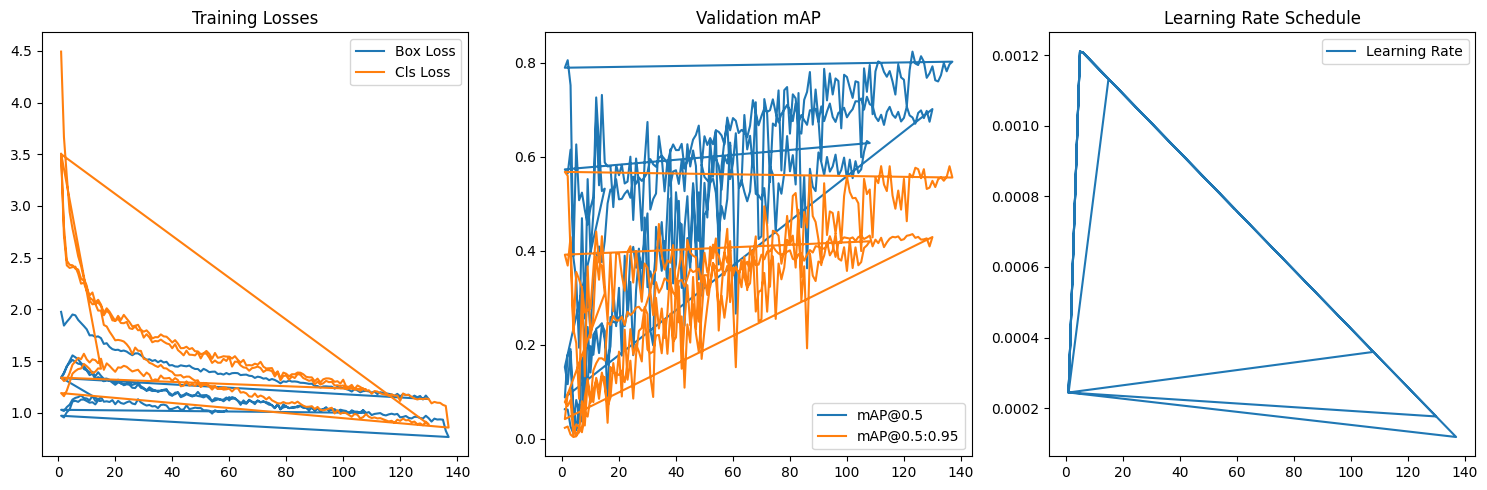

✅ All results backed up to: /content/drive/MyDrive/conveyor_a100_results


In [ ]:
if 'results' in locals():
    print(f"\n💾 Backing up results to Google Drive...")

    # Create backup directory in Drive
    backup_dir = "/content/drive/MyDrive/conveyor_a100_results"
    os.makedirs(backup_dir, exist_ok=True)

    # Copy important files
    results_dir = Path(results.save_dir)

    # Copy weights
    weights_src = results_dir / "weights"
    weights_dst = Path(backup_dir) / "weights"
    if weights_src.exists():
        shutil.copytree(str(weights_src), str(weights_dst), dirs_exist_ok=True)
        print("✅ Weights backed up")

    # Copy training plots
    for plot_file in results_dir.glob("*.png"):
        shutil.copy2(str(plot_file), backup_dir)
    print("✅ Training plots backed up")

    # Copy results CSV
    results_csv = results_dir / "results.csv"
    if results_csv.exists():
        shutil.copy2(str(results_csv), backup_dir)

        # Display training curve
        try:
            df = pd.read_csv(results_csv)
            plt.figure(figsize=(15, 5))

            plt.subplot(1, 3, 1)
            plt.plot(df['epoch'], df['train/box_loss'], label='Box Loss')
            plt.plot(df['epoch'], df['train/cls_loss'], label='Cls Loss')
            plt.title('Training Losses')
            plt.legend()

            plt.subplot(1, 3, 2)
            plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='mAP@0.5')
            plt.plot(df['epoch'], df['metrics/mAP50-95(B)'], label='mAP@0.5:0.95')
            plt.title('Validation mAP')
            plt.legend()

            plt.subplot(1, 3, 3)
            plt.plot(df['epoch'], df['lr/pg0'], label='Learning Rate')
            plt.title('Learning Rate Schedule')
            plt.legend()

            plt.tight_layout()
            plt.savefig(f"{backup_dir}/training_summary.png", dpi=300, bbox_inches='tight')
            plt.show()

        except Exception as e:
            print(f"⚠️ Could not create training plots: {e}")

    print(f"✅ All results backed up to: {backup_dir}")

CELL 10: Test Inference & Model Export

In [ ]:
if 'best_model' in locals():
    print(f"\n🧪 Testing inference on sample images...")

    # Test inference
    test_dir = DATASET_DIR / "test" / "images"
    if test_dir.exists():
        test_results = best_model.predict(
            source=str(test_dir),
            conf=0.25,
            iou=0.45,
            save=True,
            project='runs/detect',
            name='test_a100',
            exist_ok=True,
            imgsz=config['imgsz'],
            max_det=100,
            line_thickness=2,
            show_labels=True,
            show_conf=True
        )
        print("✅ Test inference completed!")
        print(f"📁 Results saved to: runs/detect/test_a100/")

    # Export model for production
    print(f"\n📦 Exporting model for production...")
    try:
        # Export to ONNX for production deployment
        best_model.export(
            format='onnx',
            imgsz=config['imgsz'],
            dynamic=False,
            simplify=True,
            opset=12
        )
        print("✅ ONNX model exported")

        # Export to TensorRT for NVIDIA GPU inference
        # best_model.export(format='engine', imgsz=config['imgsz'])
        # print("✅ TensorRT engine exported")

    except Exception as e:
        print(f"⚠️ Export failed: {e}")


🧪 Testing inference on sample images...
WARNING ⚠️ 'line_thickness' is deprecated and will be removed in in the future. Use 'line_width' instead.

image 1/115 /content/dataset/test/images/10-1-_jpeg.rf.c1d425ced26c4675f8dc7e1a8701a5af.jpg: 256x256 (no detections), 9.2ms
image 2/115 /content/dataset/test/images/11-14-_jpeg.rf.19ce0edb34a5b4095381624a215fe214.jpg: 256x256 1 patch work, 8.6ms
image 3/115 /content/dataset/test/images/11-20-_jpeg.rf.4a3fd2d220479fd16be92027f26d6f06.jpg: 256x256 1 Tear, 9.3ms
image 4/115 /content/dataset/test/images/12-1-_jpeg.rf.9002f7fbee3492a1bc9f354a48ec67b8.jpg: 256x256 (no detections), 9.1ms
image 5/115 /content/dataset/test/images/12-13-_jpeg.rf.5ac152586cfb1836ad11b7fadd0e400e.jpg: 256x256 1 patch work, 9.2ms
image 6/115 /content/dataset/test/images/13-4-_jpeg.rf.c452df6e4efa1cfeb9b7043a6732da48.jpg: 256x256 (no detections), 9.2ms
image 7/115 /content/dataset/test/images/13-8-_jpeg.rf.1d918d847a1751643267bc3e8ff60eda.jpg: 256x256 1 Hole, 1 Tear, 8.8

CELL 11: Final Summary & Download

In [ ]:
print(f"\n" + "="*70)
print("🎉 A100 TRAINING COMPLETED SUCCESSFULLY!")
print("="*70)

if 'results' in locals():
    print(f"🏆 Best Model: {results.save_dir}/weights/best.pt")
    print(f"📊 Training Results: {results.save_dir}/results.csv")
    print(f"📈 Training Plots: {results.save_dir}/*.png")
    print(f"💾 Drive Backup: {backup_dir}")
    print(f"🧪 Test Results: runs/detect/test_a100/")

print(f"\n🚀 A100 Performance Benefits:")
print(f"✅ Ultra-large batch size (64) for stable training")
print(f"✅ High-resolution images (832px) for better accuracy")
print(f"✅ Advanced augmentations (mixup, copy-paste)")
print(f"✅ Full RAM caching for maximum speed")
print(f"✅ Multi-worker data loading (8 workers)")

print(f"\n💡 Usage in Production:")
print(f"   # Load trained model")
print(f"   model = YOLO('{results.save_dir if 'results' in locals() else 'path'}/weights/best.pt')")
print(f"   # Run inference")
print(f"   results = model.predict('image.jpg', conf=0.25)")

# Optional download
download_model = input(f"\n📥 Download best model to local computer? (y/n): ").lower()
if download_model == 'y' and 'results' in locals():
    try:
        files.download(f"{results.save_dir}/weights/best.pt")
        print("✅ Model downloaded!")
    except Exception as e:
        print(f"⚠️ Download failed: {e}")

print(f"\n🎯 Training Complete! Your A100-optimized conveyor belt damage detection model is ready!")

# Show final GPU memory usage
show_gpu_memory()



🎉 A100 TRAINING COMPLETED SUCCESSFULLY!
🏆 Best Model: runs/detect/conveyor_a100_ultra/weights/best.pt
📊 Training Results: runs/detect/conveyor_a100_ultra/results.csv
📈 Training Plots: runs/detect/conveyor_a100_ultra/*.png
💾 Drive Backup: /content/drive/MyDrive/conveyor_a100_results
🧪 Test Results: runs/detect/test_a100/

🚀 A100 Performance Benefits:
✅ Ultra-large batch size (64) for stable training
✅ High-resolution images (832px) for better accuracy
✅ Advanced augmentations (mixup, copy-paste)
✅ Full RAM caching for maximum speed
✅ Multi-worker data loading (8 workers)

💡 Usage in Production:
   # Load trained model
   model = YOLO('runs/detect/conveyor_a100_ultra/weights/best.pt')
   # Run inference
   results = model.predict('image.jpg', conf=0.25)

📥 Download best model to local computer? (y/n): y


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✅ Model downloaded!

🎯 Training Complete! Your A100-optimized conveyor belt damage detection model is ready!
🔥 GPU Memory: 0.1GB used, 0.3GB cached, 22.2GB total
